# Quá trình ARIMA cho chuỗi thời gian không dừng

### Mô phỏng quá trình không dừng

In [1]:
import numpy as np
import matplotlib.pyplot as plt

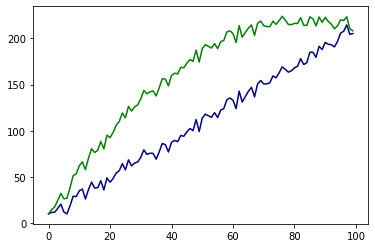

In [13]:
# Sinh quá trình ngẫu nhiên có xu thế tất định
n = 100
at = 5*np.random.randn(n)
y1t = np.array([10 + 2*t + at[t] for t in range(n)])
y2t = np.array([10 + 5*t - 0.03*pow(t,2) + at[t] for t in range(n)])

# Vẽ đồ thị
plt.plot(y1t, color='navy')
plt.plot(y2t, color='green')
plt.show()


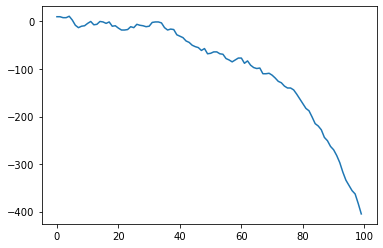

In [16]:
y3t = np.full(n,10)
for i in range(1,n):
    y3t[i]= 1.05*y3t[i-1]+at[i]
    
plt.plot(y3t)
plt.show()

### Mô phỏng bước ngẫu nhiên
$$y_t = y_{t-1} + a_t$$
$$y_t = y_{t-1} + 2+ a_t$$

$$a_t \sim WN(0,25)$$

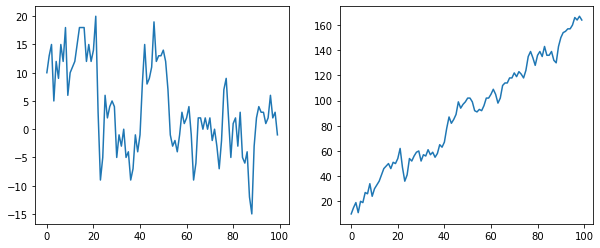

In [19]:
n = 100
at = 5*np.random.randn(n)
y4t = np.full(n,10)
y5t = np.full(n,10)
for i in range(1,n):
    y4t[i] = y4t[i-1] + at[i]
    y5t[i] = y5t[i-1] + 2 + at[i]
    
    
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(y4t)
ax[1].plot(y5t)
plt.show()

### Mô phỏng quá trình ARiMA
$$\nabla^2 y_t = a_t <=> y_t = t_{}$$
$$\nabla^2 y_t = 2+ a_t$$

$$y_0=y_1=10, a_t \sim WN(0,9)$$



In [ ]:
N = 100
AT = 3*np.random.randn(n)
y6t = np.full(n,10)
y7t = np.full(n,10)
for i in range(1,n):
    y6t[i]= 2*y6t[i-1] - y6t[i-2] + at[i]
    y7t[i]= 2*y7t[i-1] + 2 + at[i]